<a href="https://colab.research.google.com/github/pratx08/Gen-AI/blob/main/Gen_AI_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Load Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Flatten images for logistic regression (28x28 -> 784)
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

# For GAN, we normalize to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

Train shape: (60000, 28, 28) Test shape: (10000, 28, 28)


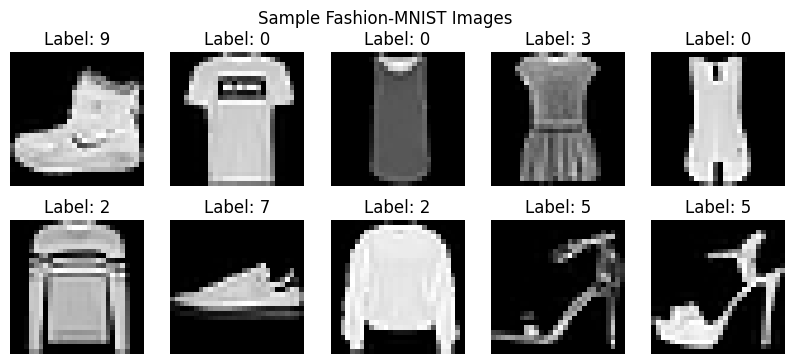

In [5]:
# Plot first 10 samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.suptitle("Sample Fashion-MNIST Images")
plt.show()

Logistic Regression Accuracy: 0.8436

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.72      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.74      0.77      0.75      1000
           5       0.95      0.92      0.93      1000
           6       0.62      0.57      0.60      1000
           7       0.91      0.94      0.93      1000
           8       0.93      0.94      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



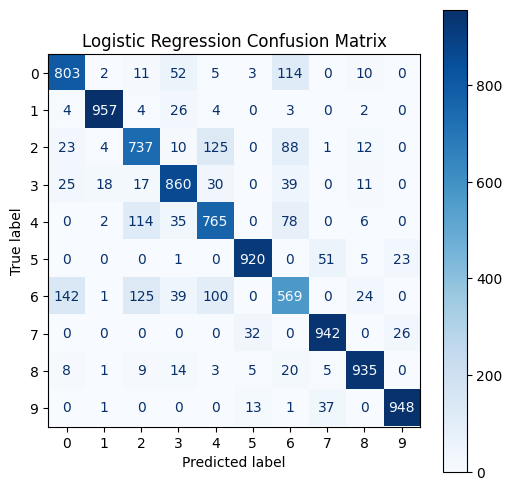

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Flatten and normalize for Logistic Regression
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, y_train)

# Predictions
y_pred = lr_model.predict(X_test_flat)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Step 200/1000 | Loss D: 0.9964 | Loss G: 0.8036
Step 400/1000 | Loss D: 0.6481 | Loss G: 1.2252
Step 600/1000 | Loss D: 0.5020 | Loss G: 1.4812
Step 800/1000 | Loss D: 0.5643 | Loss G: 1.3038
Step 1000/1000 | Loss D: 0.5628 | Loss G: 1.3549


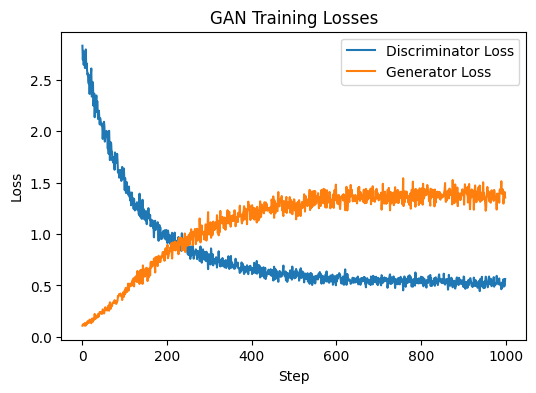

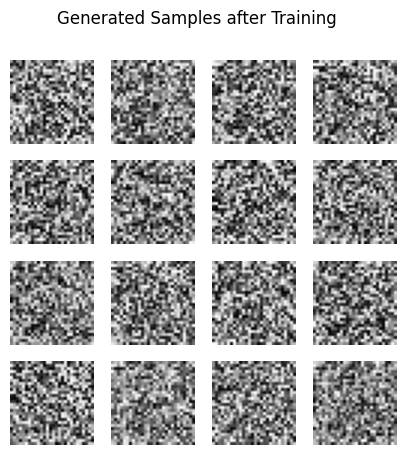

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Preprocess data for GAN
# -----------------------------
X_train_flat = X_train.reshape(-1, 28*28)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

# -----------------------------
# Hyperparameters
# -----------------------------
noise_dim = 100
hidden_dim = 128
batch_size = 128
num_steps = 1000
lr = 0.0002

rng = np.random.default_rng(seed=42)

def init_weights(shape):
    return rng.normal(0, 0.1, size=shape)

# -----------------------------
# Initialize weights
# -----------------------------
# Generator
W1_g = init_weights((noise_dim, hidden_dim))
b1_g = np.zeros(hidden_dim)
W2_g = init_weights((hidden_dim, 28*28))
b2_g = np.zeros(28*28)

# Discriminator
W1_d = init_weights((28*28, hidden_dim))
b1_d = np.zeros(hidden_dim)
W2_d = init_weights((hidden_dim, 1))
b2_d = np.zeros(1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# -----------------------------
# Training loop
# -----------------------------
losses_d, losses_g = [], []

for step in range(num_steps):
    # ---- Real batch ----
    idx = rng.choice(len(X_train_gan), size=batch_size, replace=False)
    real_batch = X_train_gan[idx]

    # ---- Fake batch ----
    z = rng.normal(0, 1, size=(batch_size, noise_dim))
    g_h_pre = z @ W1_g + b1_g
    g_h = np.maximum(0, g_h_pre)
    g_pre = g_h @ W2_g + b2_g
    fake_batch = np.tanh(g_pre)

    # ---- Discriminator ----
    d_h_pre_real = real_batch @ W1_d + b1_d
    d_h_real = np.maximum(0, d_h_pre_real)
    d_logits_real = d_h_real @ W2_d + b2_d
    d_out_real = sigmoid(d_logits_real)

    d_h_pre_fake = fake_batch @ W1_d + b1_d
    d_h_fake = np.maximum(0, d_h_pre_fake)
    d_logits_fake = d_h_fake @ W2_d + b2_d
    d_out_fake = sigmoid(d_logits_fake)

    # ---- Losses ----
    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    losses_d.append(loss_d)
    losses_g.append(loss_g)

    # ---- Backprop for Discriminator ----
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    d_delta_real = (d_out_real - y_real) / batch_size
    d_delta_fake = (d_out_fake - y_fake) / batch_size
    grad_W2_d = d_h_real.T @ d_delta_real + d_h_fake.T @ d_delta_fake
    grad_b2_d = np.sum(d_delta_real + d_delta_fake, axis=0)
    d_grad_h_real = d_delta_real @ W2_d.T
    d_grad_h_real[d_h_pre_real <= 0] = 0
    d_grad_h_fake = d_delta_fake @ W2_d.T
    d_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_W1_d = real_batch.T @ d_grad_h_real + fake_batch.T @ d_grad_h_fake
    grad_b1_d = np.sum(d_grad_h_real + d_grad_h_fake, axis=0)

    # Update Discriminator
    W2_d -= lr * grad_W2_d
    b2_d -= lr * grad_b2_d
    W1_d -= lr * grad_W1_d
    b1_d -= lr * grad_b1_d

    # ---- Backprop for Generator ----
    y_gen = np.ones((batch_size, 1))
    g_delta_d = (d_out_fake - y_gen) / batch_size
    g_grad_h_fake = g_delta_d @ W2_d.T
    g_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_fake_input = g_grad_h_fake @ W1_d.T
    grad_g_pre = grad_fake_input * (1 - fake_batch**2)
    grad_W2_g = g_h.T @ grad_g_pre
    grad_b2_g = np.sum(grad_g_pre, axis=0)
    g_grad_h = grad_g_pre @ W2_g.T
    g_grad_h[g_h_pre <= 0] = 0
    grad_W1_g = z.T @ g_grad_h
    grad_b1_g = np.sum(g_grad_h, axis=0)

    # Update Generator
    W2_g -= lr * grad_W2_g
    b2_g -= lr * grad_b2_g
    W1_g -= lr * grad_W1_g
    b1_g -= lr * grad_b1_g

    if (step+1) % 200 == 0:
        print(f"Step {step+1}/{num_steps} | Loss D: {loss_d:.4f} | Loss G: {loss_g:.4f}")

# -----------------------------
# Plot Loss Curves
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()

# -----------------------------
# Generate and Visualize Samples
# -----------------------------
z_sample = rng.normal(0, 1, size=(16, noise_dim))
g_h_pre = z_sample @ W1_g + b1_g
g_h = np.maximum(0, g_h_pre)
g_pre = g_h @ W2_g + b2_g
fake_samples = np.tanh(g_pre)

fig, axes = plt.subplots(4, 4, figsize=(5,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_samples[i].reshape(28,28), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Samples after Training")
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Load and preprocess dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

print("Train shape:", X_train_flat.shape, "Test shape:", X_test_flat.shape)

Train shape: (60000, 784) Test shape: (10000, 784)


In [9]:
# Use smaller subset for faster training
subset_size = 5000
X_train_sub, y_train_sub = X_train_flat[:subset_size], y_train[:subset_size]
X_test_sub, y_test_sub = X_test_flat[:1000], y_test[:1000]

# SVM (RBF kernel)
svm_clf = SVC(kernel="rbf", gamma="scale")
svm_clf.fit(X_train_sub, y_train_sub)
print("SVM accuracy:", accuracy_score(y_test_sub, svm_clf.predict(X_test_sub)))

# Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=20)
tree_clf.fit(X_train_sub, y_train_sub)
print("Decision Tree accuracy:", accuracy_score(y_test_sub, tree_clf.predict(X_test_sub)))

SVM accuracy: 0.859
Decision Tree accuracy: 0.747


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogReg L2 Accuracy (5k): 0.82


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg L1 Accuracy (5k): 0.823


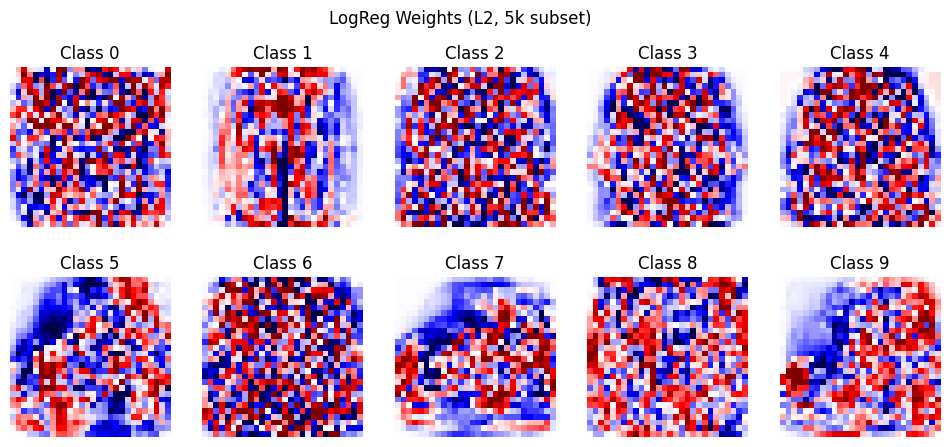

In [10]:
# -----------------------------
# Logistic Regression on 5k subset
# -----------------------------
subset_size = 5000
X_sub, y_sub = X_train_flat[:subset_size], y_train[:subset_size]
X_test_sub, y_test_sub = X_test_flat[:1000], y_test[:1000]

# L2 regularization
lr_l2 = LogisticRegression(penalty="l2", max_iter=300, solver="lbfgs")
lr_l2.fit(X_sub, y_sub)
print("LogReg L2 Accuracy (5k):", accuracy_score(y_test_sub, lr_l2.predict(X_test_sub)))

# L1 regularization
lr_l1 = LogisticRegression(penalty="l1", solver="saga", max_iter=300)
lr_l1.fit(X_sub, y_sub)
print("LogReg L1 Accuracy (5k):", accuracy_score(y_test_sub, lr_l1.predict(X_test_sub)))

# Heatmaps for L2 weights
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(lr_l2.coef_[i].reshape(28, 28), cmap="seismic", vmin=-0.5, vmax=0.5)
    ax.set_title(f"Class {i}")
    ax.axis("off")
plt.suptitle("LogReg Weights (L2, 5k subset)")
plt.show()


In [11]:
# -----------------------------
# Cross-validation on 2k subset
# -----------------------------
from sklearn.model_selection import cross_val_score

subset_size = 2000
X_cv, y_cv = X_train_flat[:subset_size], y_train[:subset_size]

lr_cv = LogisticRegression(max_iter=300, solver="lbfgs")
scores = cross_val_score(lr_cv, X_cv, y_cv, cv=5)

print("Cross-val mean accuracy:", np.mean(scores))
print("Cross-val std dev     :", np.std(scores))


Cross-val mean accuracy: 0.8104999999999999
Cross-val std dev     : 0.01713184169901181


Step 100/500 | Loss D: 1.1566 | Loss G: 0.6783
Step 200/500 | Loss D: 0.9528 | Loss G: 0.7101
Step 300/500 | Loss D: 0.8721 | Loss G: 0.7363
Step 400/500 | Loss D: 0.7795 | Loss G: 0.8279
Step 500/500 | Loss D: 0.6884 | Loss G: 0.8712


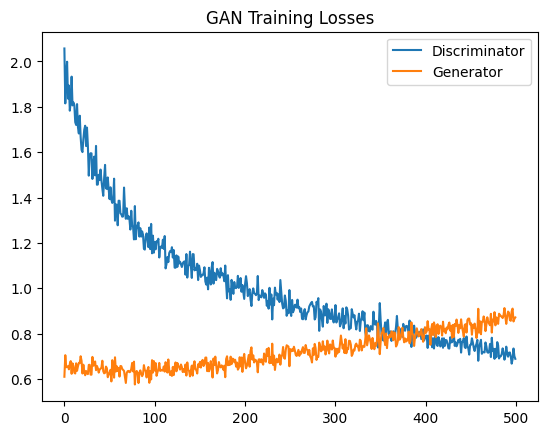

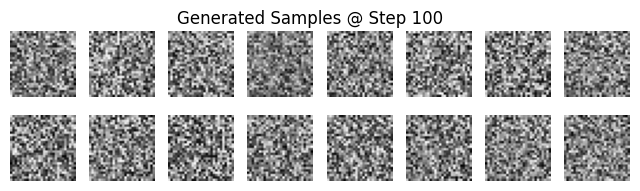

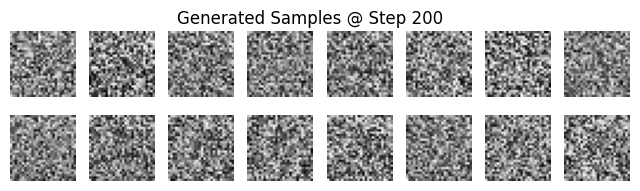

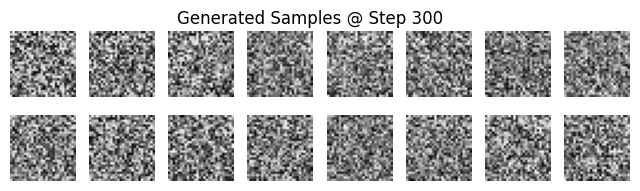

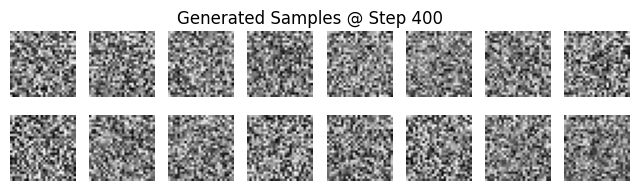

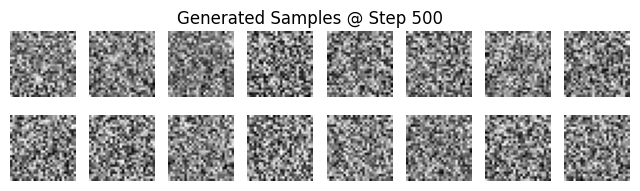

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import fashion_mnist

# -----------------------------
# Data prep
# -----------------------------
(X_train, _), (_, _) = fashion_mnist.load_data()
X_train_flat = X_train.reshape(-1, 28*28)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

# -----------------------------
# Hyperparameters
# -----------------------------
noise_dim = 100
hidden_dim = 64
batch_size = 64
num_steps = 500
lr = 0.0002

rng = np.random.default_rng(seed=42)
def init_weights(shape): return rng.normal(0, 0.1, size=shape)

# Generator params
W1_g, b1_g = init_weights((noise_dim, hidden_dim)), np.zeros(hidden_dim)
W2_g, b2_g = init_weights((hidden_dim, 28*28)), np.zeros(28*28)

# Discriminator params
W1_d, b1_d = init_weights((28*28, hidden_dim)), np.zeros(hidden_dim)
W2_d, b2_d = init_weights((hidden_dim, 1)), np.zeros(1)

def sigmoid(x): return 1 / (1 + np.exp(-x))

# -----------------------------
# Training loop with snapshots
# -----------------------------
losses_d, losses_g, snapshots = [], [], {}

for step in range(num_steps):
    # ---- Real batch ----
    idx = rng.choice(len(X_train_gan), size=batch_size, replace=False)
    real_batch = X_train_gan[idx]

    # ---- Fake batch ----
    z = rng.normal(0, 1, size=(batch_size, noise_dim))
    g_h = np.maximum(0, z @ W1_g + b1_g)
    fake_batch = np.tanh(g_h @ W2_g + b2_g)

    # ---- Discriminator ----
    d_h_real = np.maximum(0, real_batch @ W1_d + b1_d)
    d_out_real = sigmoid(d_h_real @ W2_d + b2_d)

    d_h_fake = np.maximum(0, fake_batch @ W1_d + b1_d)
    d_out_fake = sigmoid(d_h_fake @ W2_d + b2_d)

    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    losses_d.append(loss_d)
    losses_g.append(loss_g)

    # ---- Discriminator backprop ----
    y_real, y_fake = np.ones((batch_size, 1)), np.zeros((batch_size, 1))
    d_delta_real = (d_out_real - y_real) / batch_size
    d_delta_fake = (d_out_fake - y_fake) / batch_size

    grad_W2_d = d_h_real.T @ d_delta_real + d_h_fake.T @ d_delta_fake
    grad_b2_d = np.sum(d_delta_real + d_delta_fake, axis=0)
    d_grad_h_real = (d_delta_real @ W2_d.T); d_grad_h_real[d_h_real <= 0] = 0
    d_grad_h_fake = (d_delta_fake @ W2_d.T); d_grad_h_fake[d_h_fake <= 0] = 0
    grad_W1_d = real_batch.T @ d_grad_h_real + fake_batch.T @ d_grad_h_fake
    grad_b1_d = np.sum(d_grad_h_real + d_grad_h_fake, axis=0)

    W2_d -= lr * grad_W2_d; b2_d -= lr * grad_b2_d
    W1_d -= lr * grad_W1_d; b1_d -= lr * grad_b1_d

    # ---- Generator backprop ----
    g_delta_d = (d_out_fake - 1) / batch_size
    g_grad_h_fake = (g_delta_d @ W2_d.T); g_grad_h_fake[d_h_fake <= 0] = 0
    grad_fake_input = g_grad_h_fake @ W1_d.T
    grad_g_pre = grad_fake_input * (1 - fake_batch**2)
    grad_W2_g = g_h.T @ grad_g_pre; grad_b2_g = np.sum(grad_g_pre, axis=0)
    g_grad_h = grad_g_pre @ W2_g.T; g_grad_h[g_h <= 0] = 0
    grad_W1_g = z.T @ g_grad_h; grad_b1_g = np.sum(g_grad_h, axis=0)

    W2_g -= lr * grad_W2_g; b2_g -= lr * grad_b2_g
    W1_g -= lr * grad_W1_g; b1_g -= lr * grad_b1_g

    # ---- Save progress every 100 steps ----
    if (step+1) % 100 == 0:
        z_sample = rng.normal(0, 1, size=(16, noise_dim))
        g_h = np.maximum(0, z_sample @ W1_g + b1_g)
        fake_samples = np.tanh(g_h @ W2_g + b2_g)
        snapshots[step+1] = fake_samples

        print(f"Step {step+1}/{num_steps} | Loss D: {loss_d:.4f} | Loss G: {loss_g:.4f}")

# -----------------------------
# Plot Loss Curves
# -----------------------------
plt.plot(losses_d, label="Discriminator")
plt.plot(losses_g, label="Generator")
plt.legend(); plt.title("GAN Training Losses"); plt.show()

# -----------------------------
# Show Generator Progress
# -----------------------------
for step, samples in snapshots.items():
    fig, axes = plt.subplots(2, 8, figsize=(8,2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].reshape(28,28), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Generated Samples @ Step {step}")
    plt.show()
